In [1]:
from datetime import timedelta
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import pandas as pd
import numpy as np
import keras
from keras import layers
from matplotlib import pyplot as plt
import sys



def read_dataset(file):
    df = pd.read_csv(file, parse_dates=True, index_col="timestamp",header=0)
    return df

# Generated training sequences for use in the model.
def create_sequences(values, time_steps):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

def pre_processing(df,time_steps):
    df = df.dropna()
    training_mean = df.mean()
    training_std = df.std()
    df_training_value = (df - training_mean) / training_std
    print("Number of training samples:", len(df_training_value))
    x_train = create_sequences(df_training_value,time_steps)
    print("Training input shape: ", x_train.shape)
    return x_train, training_mean, training_std






# x_train = create_sequences(df_training_value)
# print("Training input shape: ", x_train.shape)
def build_model(x_train):
    n_steps = x_train.shape[1]
    n_features = x_train.shape[2]
    model = keras.Sequential(
        [
            layers.Input(shape=(n_steps, n_features)),
            layers.Conv1D(filters=32, kernel_size=15, padding='same', data_format='channels_last',
                dilation_rate=1, activation="linear"),
            layers.LSTM(
                units=25, activation="tanh", name="lstm_1", return_sequences=False
            ),
            layers.RepeatVector(n_steps),
            layers.LSTM(
                units=25, activation="tanh", name="lstm_2", return_sequences=True
            ),
            layers.Conv1D(filters=32, kernel_size=15, padding='same', data_format='channels_last',
                dilation_rate=1, activation="linear"),
            layers.TimeDistributed(layers.Dense(x_train.shape[2], activation='linear'))
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    model.summary()
    return model



def save_res(train_mae_loss,training_mean,training_std):
    plt.hist(train_mae_loss, bins=50)
    plt.xlabel("Training MAE")
    plt.ylabel("No of samples")
    plt.savefig("../res/training_MAE_loss.jpg")

    # Get reconstruction loss threshold.
    threshold = np.max(train_mae_loss)
    mesg = "threshold="+str(threshold)+"\n"+"training_mean="+str(list(training_mean))+"\n"+"training_std="+str(list(training_std))+"\n"+"time_steps="+str(int(TIME_STEPS))
    print("Reconstruction error threshold: ", threshold)

    model.save('../res/model.keras') 
    with open("training_var.py","w") as f:
        f.write(mesg)
    print("Model Saved")

In [2]:
TIME_STEPS = int(24*7)
# if len(sys.argv) > 1:
#     TIME_STEPS = int(sys.argv[1])
print (TIME_STEPS)
df = read_dataset('../data/train.csv')
x_train, training_mean, training_std = pre_processing(df,TIME_STEPS)
model  = build_model(x_train)

history = model.fit(
    x_train,
    x_train,
    epochs=2,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=25, mode="min")
    ],
)

168
Number of training samples: 13896
Training input shape:  (13729, 168, 2)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 168, 32)           992       
                                                                 
 lstm_1 (LSTM)               (None, 25)                5800      
                                                                 
 repeat_vector (RepeatVector  (None, 168, 25)          0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 168, 25)           5100      
                                                                 
 conv1d_1 (Conv1D)           (None, 168, 32)           12032     
                                                                 
 time_distributed (TimeDistr  (None, 168, 2) 

In [3]:
print("Calculating Training MAE Loss")
x_train_pred = model.predict(x_train)

Calculating Training MAE Loss
430/430 [==============================] - 9s 19ms/step


In [4]:
x_train_pred.shape

(13729, 168, 2)

In [5]:
x_train

array([[[ 0.04893118,  0.04893118],
        [-0.16852572, -0.16852572],
        [ 0.27973701,  0.27973701],
        ...,
        [ 0.12367963,  0.12367963],
        [ 0.13097225,  0.13097225],
        [-0.50846141, -0.50846141]],

       [[-0.16852572, -0.16852572],
        [ 0.27973701,  0.27973701],
        [ 0.24056689,  0.24056689],
        ...,
        [ 0.13097225,  0.13097225],
        [-0.50846141, -0.50846141],
        [-0.18622233, -0.18622233]],

       [[ 0.27973701,  0.27973701],
        [ 0.24056689,  0.24056689],
        [ 0.21685399,  0.21685399],
        ...,
        [-0.50846141, -0.50846141],
        [-0.18622233, -0.18622233],
        [-0.04874744, -0.04874744]],

       ...,

       [[-0.97640539, -0.97640539],
        [-1.37220477, -1.37220477],
        [-1.39513144, -1.39513144],
        ...,
        [-1.37610001, -1.37610001],
        [-1.13946177, -1.13946177],
        [-0.96459216, -0.96459216]],

       [[-1.37220477, -1.37220477],
        [-1.39513144, -1.39

In [6]:
x_train_pred

array([[[-0.09696697, -0.11046512],
        [-0.09821392, -0.09343665],
        [-0.08766912, -0.08505655],
        ...,
        [-0.3676481 , -0.31670105],
        [-0.3318029 , -0.26556945],
        [-0.34177592, -0.31342804]],

       [[-0.10053995, -0.11290564],
        [-0.09985053, -0.09447443],
        [-0.08751035, -0.08430521],
        ...,
        [-0.4012837 , -0.34554672],
        [-0.36277148, -0.29588363],
        [-0.3724099 , -0.33678803]],

       [[-0.10165723, -0.11661149],
        [-0.0987596 , -0.09680897],
        [-0.08376426, -0.08532243],
        ...,
        [-0.35032192, -0.29477543],
        [-0.31858495, -0.25272712],
        [-0.33867875, -0.2990642 ]],

       ...,

       [[-0.1752049 , -0.13734207],
        [-0.32393107, -0.2873908 ],
        [-0.4699705 , -0.42373547],
        ...,
        [-0.08516219, -0.11436974],
        [ 0.0112204 ,  0.0310663 ],
        [ 0.24094394,  0.26747409]],

       [[-0.19703773, -0.16066372],
        [-0.35400644, -0.31

In [7]:
train_mae_loss = np.mean((np.mean(np.abs(x_train_pred - x_train), axis=1)), axis=1)

In [8]:
train_mae_loss.shape

(13729,)

Reconstruction error threshold:  0.8961955094102918
Model Saved


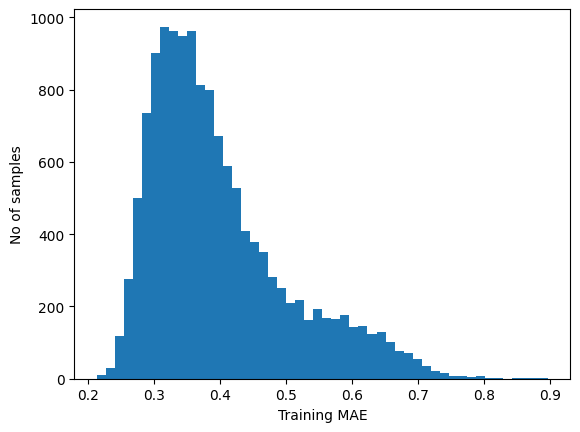

In [9]:
save_res(train_mae_loss,training_mean,training_std)

In [10]:
threshold = np.max(train_mae_loss)

In [11]:
threshold

0.8961955094102918

In [1]:
from datetime import timedelta
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import numpy as np
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt
import training_var
import sys


def read_dataset(file):
    df = pd.read_csv(file, parse_dates=True, index_col="timestamp",header=0)
    return df

# Generated training sequences for use in the model.
def create_sequences(values, time_steps):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

def pre_processing(df,TIME_STEPS):
    df = df.dropna()
    df_test_value = (df - training_var.training_mean)/ training_var.training_std
    # Create sequences from test values.
    x_test = create_sequences(df_test_value.values,TIME_STEPS)
    print("Test input shape: ", x_test.shape)
    return x_test

def univariate_anomalous_data(anomalies):
    anomalous_data_indices_raw = np.where(anomalies)[0]
    print("raw anomaly samples: ", anomalous_data_indices_raw)
    anomalous_data_indices_raw = [x+TIME_STEPS/2 for x in anomalous_data_indices_raw]
    anomalous_data_indices = []
    for data_idx in anomalous_data_indices_raw:
        if set(range(int(data_idx)-int(TIME_STEPS/4),int(data_idx)+int(TIME_STEPS/4))).issubset(set(anomalous_data_indices_raw)):
            anomalous_data_indices.append(int(data_idx))
    print("Number of anomaly samples: ", len(anomalous_data_indices))
    print("Indices of anomaly samples: ", anomalous_data_indices)
    return anomalous_data_indices

def generate_res(df_test):
    df_res = df_test.reset_index()
    df_res['res'] = False
    df_res.loc[anomalous_data_indices,'res'] = True
    df_res = df_res['res'] 
    df_res.to_csv("../res/res.csv",index=False)

In [2]:
TIME_STEPS = training_var.time_steps
df_test = read_dataset('../data/test.csv')
# df_test = pd.read_csv('../data/test.csv',parse_dates=True, index_col="timestamp",header=0)
x_test = pre_processing(df_test,TIME_STEPS)
model = keras.models.load_model('../res/model.keras')

Test input shape:  (853, 168, 2)


In [16]:
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

27/27 [==============================] - 1s 20ms/step


In [17]:
test_mae_loss.shape

(853, 1)

In [18]:
test_mae_loss

array([[0.24583492],
       [0.24530709],
       [0.23988283],
       [0.23530061],
       [0.23466073],
       [0.23211747],
       [0.22691829],
       [0.22562859],
       [0.2221147 ],
       [0.22206621],
       [0.21734948],
       [0.21369621],
       [0.21219807],
       [0.20530635],
       [0.20925745],
       [0.20922043],
       [0.21850484],
       [0.22283909],
       [0.22506483],
       [0.2240477 ],
       [0.21628623],
       [0.21456709],
       [0.21228801],
       [0.21469267],
       [0.21637185],
       [0.2160269 ],
       [0.21514701],
       [0.21252809],
       [0.21157097],
       [0.20998351],
       [0.20972647],
       [0.21158937],
       [0.21450477],
       [0.21988985],
       [0.21789274],
       [0.21321649],
       [0.21044902],
       [0.21064248],
       [0.21048559],
       [0.20325651],
       [0.19998314],
       [0.20609971],
       [0.20299504],
       [0.19953579],
       [0.20270707],
       [0.21126766],
       [0.21492309],
       [0.213

In [19]:
test_mae_loss = np.mean(test_mae_loss, axis=1)
test_mae_loss

array([0.24583492, 0.24530709, 0.23988283, 0.23530061, 0.23466073,
       0.23211747, 0.22691829, 0.22562859, 0.2221147 , 0.22206621,
       0.21734948, 0.21369621, 0.21219807, 0.20530635, 0.20925745,
       0.20922043, 0.21850484, 0.22283909, 0.22506483, 0.2240477 ,
       0.21628623, 0.21456709, 0.21228801, 0.21469267, 0.21637185,
       0.2160269 , 0.21514701, 0.21252809, 0.21157097, 0.20998351,
       0.20972647, 0.21158937, 0.21450477, 0.21988985, 0.21789274,
       0.21321649, 0.21044902, 0.21064248, 0.21048559, 0.20325651,
       0.19998314, 0.20609971, 0.20299504, 0.19953579, 0.20270707,
       0.21126766, 0.21492309, 0.21378971, 0.2146587 , 0.21433214,
       0.21472407, 0.21683909, 0.22236155, 0.22167039, 0.22548078,
       0.23255708, 0.23167951, 0.22859828, 0.23185366, 0.2356097 ,
       0.23472874, 0.23392556, 0.23883786, 0.23868654, 0.23915626,
       0.24214324, 0.24725294, 0.25227506, 0.26161532, 0.26614272,
       0.27206954, 0.2761991 , 0.27556014, 0.27606891, 0.27951

In [20]:
# test_mae_loss = test_mae_loss.reshape((-1))

In [21]:
anomalies = test_mae_loss > training_var.threshold
anomalies

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [22]:
anomalous_data_indices = univariate_anomalous_data(anomalies)


raw anomaly samples:  [353 354 355 356 362 363 364 365 366 368 369 370 371 372 373 374 375 376
 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394
 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412
 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430
 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448
 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466
 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484
 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502
 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520
 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538
 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556
 557 558 559 560 561 562 563 564]
Number of anomaly samples:  114
Indices of anomaly samples:  [494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509,

In [61]:
from datetime import timedelta
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import numpy as np
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt
import training_var
import sys
def read_dataset(file):
    df = pd.read_csv(file, parse_dates=True, index_col="timestamp",header=0)
    return df

# Generated training sequences for use in the model.
def create_sequences(values, time_steps):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

def pre_processing(df,TIME_STEPS):
    df = df.dropna()
    df_test_value = (df - training_var.training_mean) / training_var.training_std
    # Create sequences from test values.
    x_test = create_sequences(df_test_value.values,TIME_STEPS)
    print("Test input shape: ", x_test.shape)
    return x_test

def univariate_anomalous_data(anomalies):
    anomalous_data_indices_raw = np.where(anomalies)[0]
    anomalous_data_indices_raw = [x+TIME_STEPS/2 for x in anomalous_data_indices_raw]
    anomalous_data_indices = []
    for data_idx in anomalous_data_indices_raw:
        if set(range(int(data_idx)-int(TIME_STEPS/4),int(data_idx)+int(TIME_STEPS/4))).issubset(set(anomalous_data_indices_raw)):
            anomalous_data_indices.append(int(data_idx))
    print("Number of anomaly samples: ", len(anomalous_data_indices))
    print("Indices of anomaly samples: ", anomalous_data_indices)
    return anomalous_data_indices

def generate_res(df,anomalous_data_indices):
    df_res = df.reset_index()
    df_res['res'] = False
    df_res.loc[anomalous_data_indices,'res'] = True
    df_res = df_res.filter(['timestamp','res'])
    df_res.to_csv("../res/res.csv",index=False)

TIME_STEPS = training_var.time_steps
df_test = read_dataset('../data/test_multi.csv')
# df_test = pd.read_csv('../data/test.csv',parse_dates=True, index_col="timestamp",header=0)
x_test = pre_processing(df_test,TIME_STEPS)

Test input shape:  (853, 168, 2)


In [62]:
model = keras.models.load_model('../res/model.keras')


# fig, ax = plt.subplots()
# df_test_value.plot(legend=False, ax=ax)
# plt.show()


# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = np.mean(test_mae_loss, axis=1)
# test_mae_loss = test_mae_loss.reshape((-1))

# plt.hist(test_mae_loss, bins=50)
# plt.xlabel("Prediction MAE")
# plt.ylabel("No of samples")
# plt.savefig("../res/prediction MAE loss.jpg")

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > training_var.threshold


anomalous_data_indices = univariate_anomalous_data(anomalies)


generate_res(df_test,anomalous_data_indices)

27/27 [==============================] - 1s 19ms/step
Number of anomaly samples:  0
Indices of anomaly samples:  []


In [50]:
df_res = df_test
df_res['res'] = False
df_res.loc[anomalous_data_indices,'res'] = True
print(df_res.head())
df_res = df_res.filter(['timestamp','res'])

                       value1    value2    res
timestamp                                     
2022-05-31 00:00:00  0.697843  0.697843  False
2022-05-31 01:00:00 -2.559581 -2.559581  False
2022-05-31 02:00:00  4.155230  4.155230  False
2022-05-31 03:00:00  3.568476  3.568476  False
2022-05-31 04:00:00  3.213265  3.213265  False


In [45]:
df_res

,res
timestamp,
2022-05-31 00:00:00,False
2022-05-31 01:00:00,False
2022-05-31 02:00:00,False
2022-05-31 03:00:00,False
2022-05-31 04:00:00,False
...,...
2022-07-12 07:00:00,False
2022-07-12 08:00:00,False
2022-07-12 09:00:00,False
